### Note

To run this notebook, download  the imagewtype zip folder from the google drive folder and upload it to this runtime. Once it has fully uploaded (it   takes 5-10 mins), make sure the GPU hardware accelarator option is selected from Runtime->change runtime type menu. After that, the notebook will be good to run sequentially or as directed.



In [1]:
import matplotlib.pyplot as plt
import keras
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.svm import SVC
from keras.models import Sequential
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from tensorflow.keras import layers
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest, f_classif
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16
import pandas as pd
from tensorflow.keras.applications import ResNet50
import seaborn as sns
import cv2
from sklearn.linear_model import LogisticRegression 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
import sklearn
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

In [ ]:
!unzip imagewtype

#Pre-Processing

In [3]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

Next cell takes all images in training and testing and appends them together - don't worry, we split them into seperate sets afterwards.

It does the same thing with the labels.

In [4]:
X_train = []
y_train = []
image_size = 224
for i in labels:
    folderPath = os.path.join('Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 158.68it/s]


In [5]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

Next block splits into training and testing

In [6]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [7]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

# Testing modified version of my model with RFC and SVM

In [19]:
mine = Sequential([
  layers.InputLayer(input_shape=(image_size,
                                  image_size,
                                  3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(512, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(1024, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
])

In [20]:
model = mine.output
model = tf.keras.models.Model(inputs=mine.input, outputs = model)

In [21]:

featuresTrain= model.predict(X_train)

#reshape to flatten feature for Train data
featuresTrain= featuresTrain.reshape(featuresTrain.shape[0], -1)

featuresVal= model.predict(X_test)
#reshape to flatten feature for Test data
featuresVal= featuresVal.reshape(featuresVal.shape[0], -1)

11/11 [==============================] - 0s 34ms/step


In [24]:
m2=RandomForestClassifier()

In [ ]:
m2.fit(featuresTrain, np.argmax(y_train,axis=1))

In [ ]:
m2.fit(featuresTrain, np.argmax(y_train,axis=1))

# evaluate the model

results = m2.predict(featuresVal)
print (metrics.accuracy_score(results, np.argmax(y_test,axis=1)))

0.7737003058103975


Same thing again, this time with feature selection:

In [ ]:
# configure to select all features
fs = SelectKBest(score_func=mutual_info_classif, k=33) ##33 seems optimal
# learn relationship from training data
fs.fit(featuresTrain, np.argmax(y_train,axis=1))
# transform train input data
featuresTrain_fs = fs.transform(featuresTrain)
# transform test input data
featuresVal_fs = fs.transform(featuresVal)

In [ ]:
m2.fit(featuresTrain_fs, np.argmax(y_train,axis=1))

# evaluate the model

results = m2.predict(featuresVal_fs)
print (metrics.accuracy_score(results, np.argmax(y_test,axis=1)))

0.8134556574923547


In [ ]:
cm= confusion_matrix(results, np.argmax(y_test,axis=1))

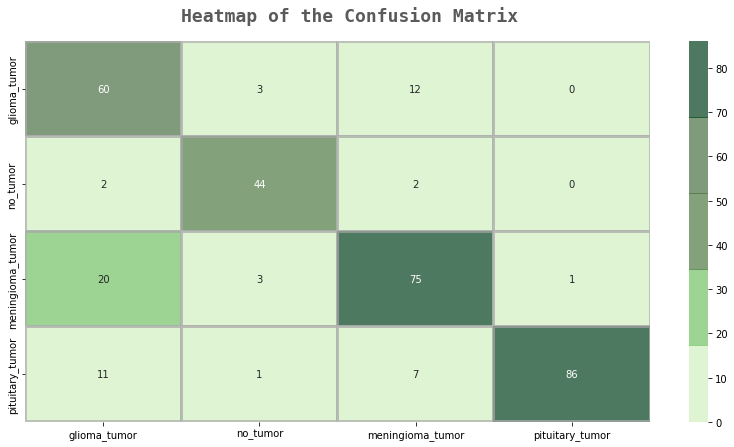

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(cm,ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

Using svm:

In [14]:
svm = SVC()




In [ ]:
svm.fit(featuresTrain, np.argmax(y_train,axis=1))

# evaluate the model

results = svm.predict(featuresVal)
print (metrics.accuracy_score(results, np.argmax(y_test,axis=1)))

In [ ]:
print(classification_report(results, np.argmax(y_test,axis=1)))

              precision    recall  f1-score   support

           0       0.53      0.69      0.60        71
           1       0.71      0.67      0.69        54
           2       0.56      0.61      0.58        89
           3       0.93      0.72      0.81       113

    accuracy                           0.67       327
   macro avg       0.68      0.67      0.67       327
weighted avg       0.71      0.67      0.68       327



In [ ]:
cm= confusion_matrix(results, np.argmax(y_test,axis=1))

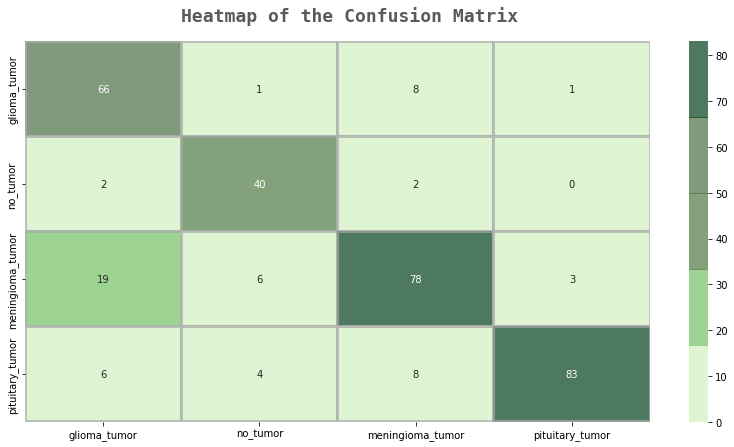

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(cm,ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

# Same process with InceptionV3:

In [8]:
inc = InceptionV3(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

87910968/87910968 [==============================] - 2s 0us/step


In [9]:
model = inc.output
model = tf.keras.models.Model(inputs=inc.input, outputs = model)

In [10]:

featuresTrain= model.predict(X_train)

#reshape to flatten feature for Train data
featuresTrain= featuresTrain.reshape(featuresTrain.shape[0], -1)

featuresVal= model.predict(X_test)
#reshape to flatten feature for Test data
featuresVal= featuresVal.reshape(featuresVal.shape[0], -1)

11/11 [==============================] - 1s 137ms/step


In [ ]:
svm.fit(featuresTrain, np.argmax(y_train,axis=1))

# evaluate the model

results = svm.predict(featuresVal)
print (metrics.accuracy_score(results, np.argmax(y_test,axis=1)))

0.8409785932721713


In [ ]:
print(classification_report(results, np.argmax(y_test,axis=1)))

              precision    recall  f1-score   support

           0       0.76      0.83      0.79        86
           1       0.94      0.86      0.90        56
           2       0.75      0.82      0.78        88
           3       0.97      0.87      0.91        97

    accuracy                           0.84       327
   macro avg       0.86      0.84      0.85       327
weighted avg       0.85      0.84      0.84       327



In [ ]:
cm= confusion_matrix(results, np.argmax(y_test,axis=1))

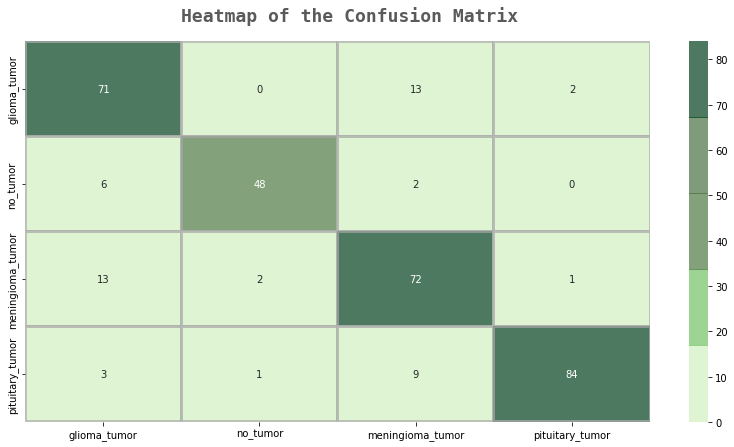

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(cm,ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

In [ ]:
m2 = RandomForestClassifier()

In [ ]:
m2.fit(featuresTrain, np.argmax(y_train,axis=1))

# evaluate the model

results = m2.predict(featuresVal)
print (metrics.accuracy_score(results, np.argmax(y_test,axis=1)))

0.8165137614678899


In [ ]:
cm= confusion_matrix(results, np.argmax(y_test,axis=1))

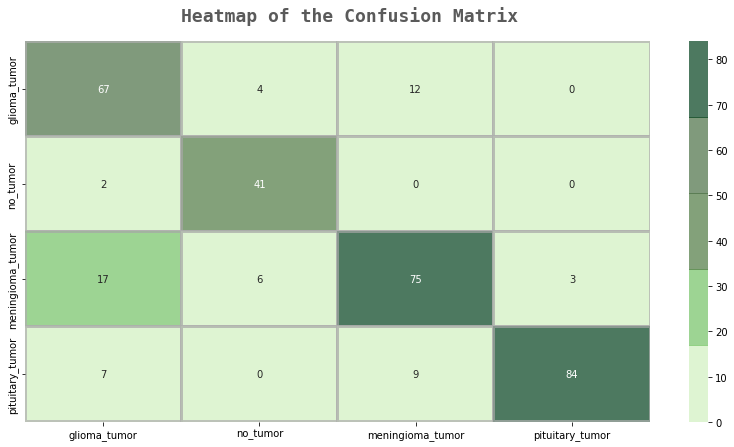

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(cm,ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

# Same process with ResNet:

In [19]:
rn = ResNet50(input_shape=(224, 224,3), include_top=False, weights="imagenet")

In [20]:
model = rn.output
model = tf.keras.models.Model(inputs=rn.input, outputs = model)

In [ ]:
model.summary()

In [10]:
featuresTrain= model.predict(X_train)

#reshape to flatten feature for Train data
featuresTrain= featuresTrain.reshape(featuresTrain.shape[0], -1)

featuresVal= model.predict(X_test)
#reshape to flatten feature for Test data
featuresVal= featuresVal.reshape(featuresVal.shape[0], -1)

11/11 [==============================] - 1s 124ms/step


In [30]:
svm.fit(featuresTrain, np.argmax(y_train,axis=1))

# evaluate the model

results = svm.predict(featuresVal)
print (metrics.accuracy_score(results, np.argmax(y_test,axis=1)))

0.9143730886850153


In [ ]:
cm= confusion_matrix(results, np.argmax(y_test,axis=1))

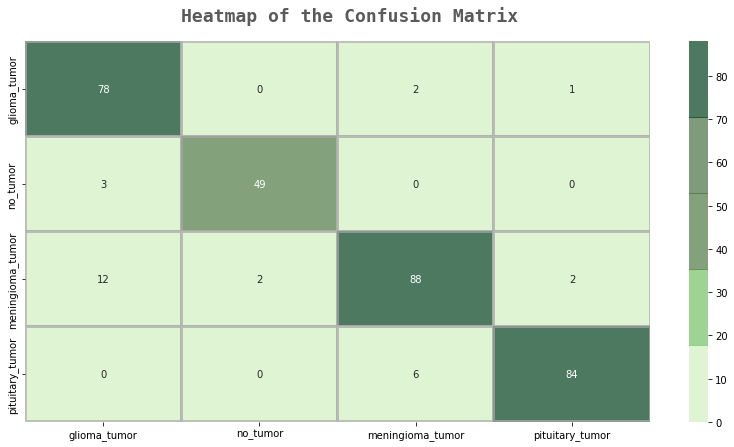

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(cm,ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

In [ ]:
svm =SVC()

In [ ]:
svm.fit(featuresTrain, np.argmax(y_train,axis=1))

# evaluate the model

results = svm.predict(featuresVal)
print (metrics.accuracy_score(results, np.argmax(y_test,axis=1)))

0.9143730886850153


Using the RFC:


In [ ]:
m2.fit(featuresTrain, np.argmax(y_train,axis=1))

# evaluate the model

results = m2.predict(featuresVal)
print (metrics.accuracy_score(results, np.argmax(y_test,axis=1)))

0.8746177370030581
